# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch

# Kullanılmayan bellekleri temizle
torch.cuda.empty_cache()

# Zorla kullanılmayan memory'yi bırak
torch.cuda.ipc_collect()

print("GPU belleği temizlendi.")


GPU belleği temizlendi.


### Preprocessing and Image Display

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm


In [4]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


In [5]:
class HistopathologySRDataset(Dataset):
    def __init__(self, image_dir, transform_hr, transform_lr):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = Image.open(img_path).convert('RGB')
        hr = self.transform_hr(img)
        lr = self.transform_lr(img)
        return lr, hr


In [6]:
transform_hr = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

transform_lr = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.Resize((512, 512)),  # back upsample
    transforms.ToTensor()
])


In [7]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device, save_path="model_epoch"):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for lr, hr in tqdm(dataloader):
            lr, hr = lr.to(device), hr.to(device)

            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            del sr, loss, lr, hr
            torch.cuda.empty_cache()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")



In [8]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = HistopathologySRDataset(image_dir='all tissue img', transform_hr=transform_hr, transform_lr=transform_lr)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = SRCNN().to(device)
criterion = nn.L1Loss()  # replace MSELoss

optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, dataloader, criterion, optimizer, num_epochs=50, device=device)



100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [05:31<00:00,  3.94s/it]


Epoch 1/50, Loss: 0.0665


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [09:34<00:00,  6.84s/it]


Epoch 2/50, Loss: 0.0199


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:03<00:00,  7.19s/it]


Epoch 3/50, Loss: 0.0178


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:02<00:00,  7.18s/it]


Epoch 4/50, Loss: 0.0168


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:21<00:00,  7.40s/it]


Epoch 5/50, Loss: 0.0160


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [09:35<00:00,  6.85s/it]


Epoch 6/50, Loss: 0.0153


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:33<00:00,  7.54s/it]


Epoch 7/50, Loss: 0.0148


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:11<00:00,  7.29s/it]


Epoch 8/50, Loss: 0.0146


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:26<00:00,  7.46s/it]


Epoch 9/50, Loss: 0.0143


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:23<00:00,  7.42s/it]


Epoch 10/50, Loss: 0.0141


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:21<00:00,  7.39s/it]


Epoch 11/50, Loss: 0.0140


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [11:09<00:00,  7.97s/it]


Epoch 12/50, Loss: 0.0141


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [10:01<00:00,  7.16s/it]


Epoch 13/50, Loss: 0.0137


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [06:36<00:00,  4.72s/it]


Epoch 14/50, Loss: 0.0136


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:38<00:00,  1.17s/it]


Epoch 15/50, Loss: 0.0135


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:31<00:00,  1.09s/it]


Epoch 16/50, Loss: 0.0136


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 17/50, Loss: 0.0135


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.06s/it]


Epoch 18/50, Loss: 0.0132


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.06s/it]


Epoch 19/50, Loss: 0.0133


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 20/50, Loss: 0.0132


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 21/50, Loss: 0.0130


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.05s/it]


Epoch 22/50, Loss: 0.0128


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.05s/it]


Epoch 23/50, Loss: 0.0129


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 24/50, Loss: 0.0128


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 25/50, Loss: 0.0129


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 26/50, Loss: 0.0129


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 27/50, Loss: 0.0126


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 28/50, Loss: 0.0124


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.05s/it]


Epoch 29/50, Loss: 0.0125


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 30/50, Loss: 0.0123


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 31/50, Loss: 0.0123


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 32/50, Loss: 0.0126


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 33/50, Loss: 0.0122


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 34/50, Loss: 0.0121


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 35/50, Loss: 0.0122


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 36/50, Loss: 0.0122


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:26<00:00,  1.03s/it]


Epoch 37/50, Loss: 0.0120


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 38/50, Loss: 0.0122


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 39/50, Loss: 0.0122


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 40/50, Loss: 0.0119


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 41/50, Loss: 0.0118


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 42/50, Loss: 0.0118


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:27<00:00,  1.04s/it]


Epoch 43/50, Loss: 0.0119


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 44/50, Loss: 0.0117


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.06s/it]


Epoch 45/50, Loss: 0.0118


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.06s/it]


Epoch 46/50, Loss: 0.0119


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:30<00:00,  1.08s/it]


Epoch 47/50, Loss: 0.0116


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.06s/it]


Epoch 48/50, Loss: 0.0116


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:28<00:00,  1.05s/it]


Epoch 49/50, Loss: 0.0118


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:29<00:00,  1.06s/it]


Epoch 50/50, Loss: 0.0116


In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show_sr_results(model, dataset, device, index=0):
    model.eval()
    with torch.no_grad():
        # Verisetinden bir örnek al
        lr, hr = dataset[index]
        lr = lr.unsqueeze(0).to(device)
        sr = model(lr).cpu().squeeze(0)

        # Tensorları görüntüye çevir
        lr_img = TF.to_pil_image(lr.squeeze(0).cpu())
        hr_img = TF.to_pil_image(hr.cpu())
        sr_img = TF.to_pil_image(torch.clamp(sr, 0, 1))  # clamp önemli!

        # Görüntüleri yan yana göster
        plt.figure(figsize=(12,4))
        plt.subplot(1, 3, 1)
        plt.title("Low-Res (Upsampled)")
        plt.imshow(lr_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Super-Res (SRCNN Output)")
        plt.imshow(sr_img)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("High-Res (Ground Truth)")
        plt.imshow(hr_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        plt.close()  # RAM’i temizle


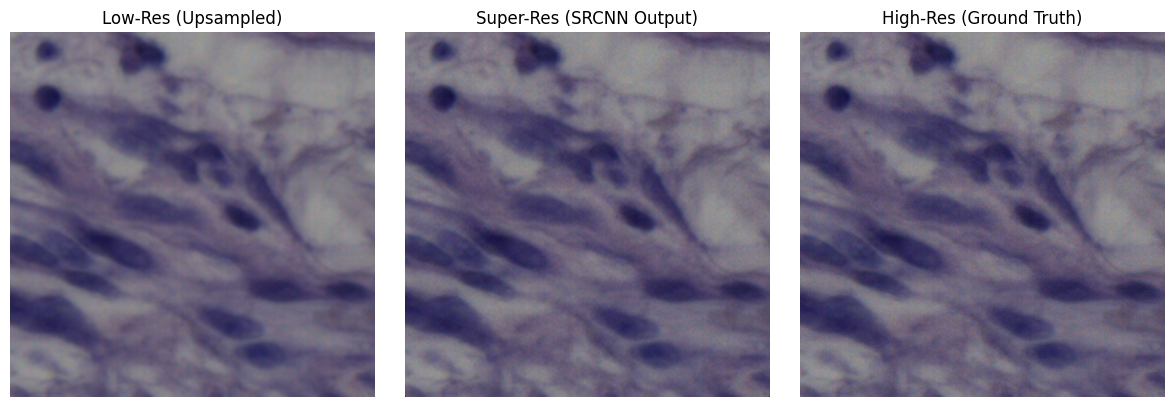

In [11]:
show_sr_results(model, dataset, device, index=0)


In [12]:
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import cv2

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
def evaluate_sr_quality(model, dataset, device, index=0):
    """
    Verilen model ve dataset ile belirtilen index'teki görüntü için
    PSNR ve SSIM değerlerini hesaplar ve görüntüleri gösterir.
    """
    model.eval()  # Modeli değerlendirme moduna al
    with torch.no_grad():
        # Dataset'ten LR ve HR görüntüyü al
        lr, hr = dataset[index]
        lr = lr.unsqueeze(0).to(device)     # Model inputu için batch dimension ekle
        hr = hr.unsqueeze(0).to(device)

        # Modelden süper çözünürlük çıktısını al
        sr = model(lr).clamp(0.0, 1.0)      # Çıktıyı 0–1 arasına kırp

        # PSNR hesapla (pytorch → numpy çevirip kullanıyoruz)
        sr_np = sr.squeeze().cpu().permute(1, 2, 0).numpy()  # CxHxW → HxWxC
        hr_np = hr.squeeze().cpu().permute(1, 2, 0).numpy()

        psnr = peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0)

        # SSIM hesapla (renkli olduğu için multichannel=True)
        ssim = structural_similarity(hr_np, sr_np, data_range=1.0, channel_axis=2)

        # Sonuçları yazdır
        print(f" PSNR: {psnr:.2f} dB")
        print(f" SSIM: {ssim:.4f}")

        # Karşılaştırmalı görsel göster

        lr_img = TF.to_pil_image(lr.squeeze(0).cpu())
        hr_img = TF.to_pil_image(hr.squeeze(0).cpu())
        sr_img = TF.to_pil_image(sr.squeeze(0).cpu())


        print("Görüntü boyutu:", sr_img.size)  # (yükseklik, genişlik, kanal sayısı)
        
        plt.figure(figsize=(12,4))
        plt.subplot(1, 3, 1)
        plt.title("Low-Res (Upsampled)")
        plt.imshow(lr_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(f"Super-Res\nPSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")
        plt.imshow(sr_img)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("High-Res (Ground Truth)")
        plt.imshow(hr_img)
        plt.axis("off")
    
        plt.tight_layout()
        plt.show()
        plt.close()  # RAM’i temizle


 PSNR: 34.81 dB
 SSIM: 0.8366
Görüntü boyutu: (512, 512)


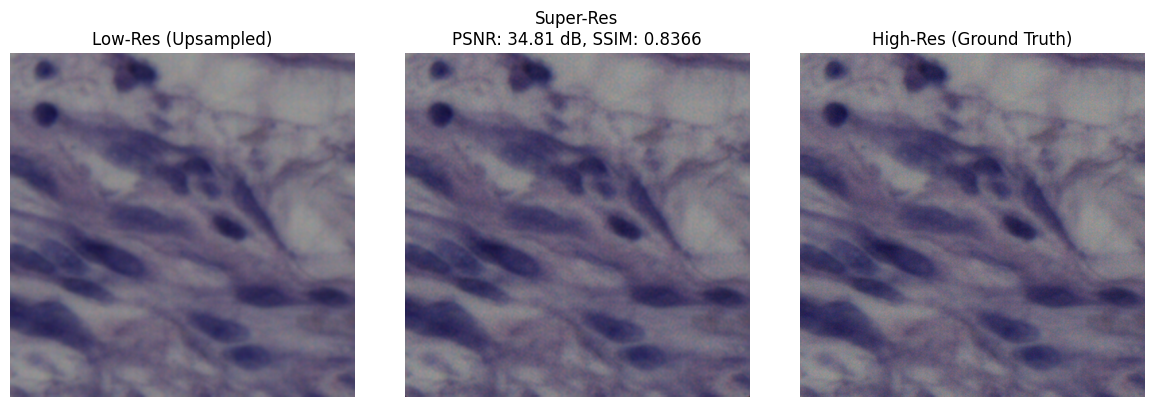

In [13]:
evaluate_sr_quality(model, dataset, device, index=0)


 PSNR: 35.06 dB
 SSIM: 0.8326
Görüntü boyutu: (512, 512)


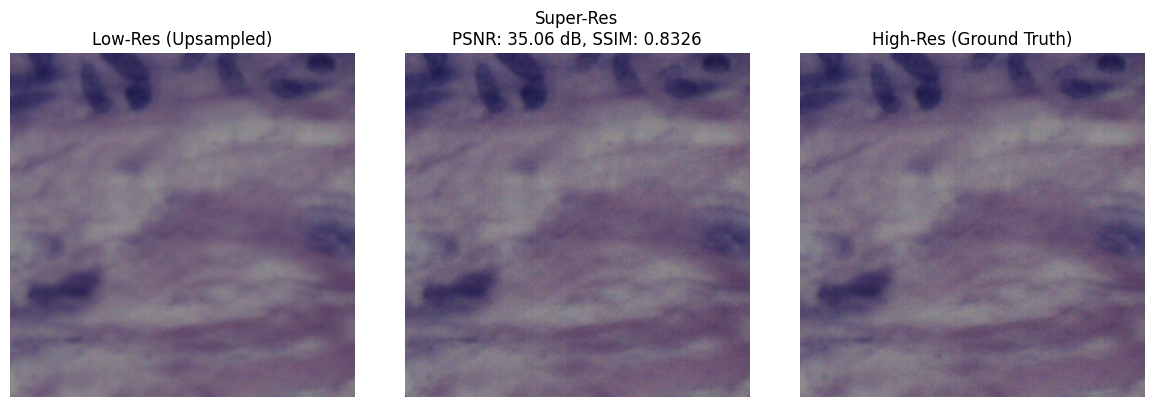

 PSNR: 34.94 dB
 SSIM: 0.8269
Görüntü boyutu: (512, 512)


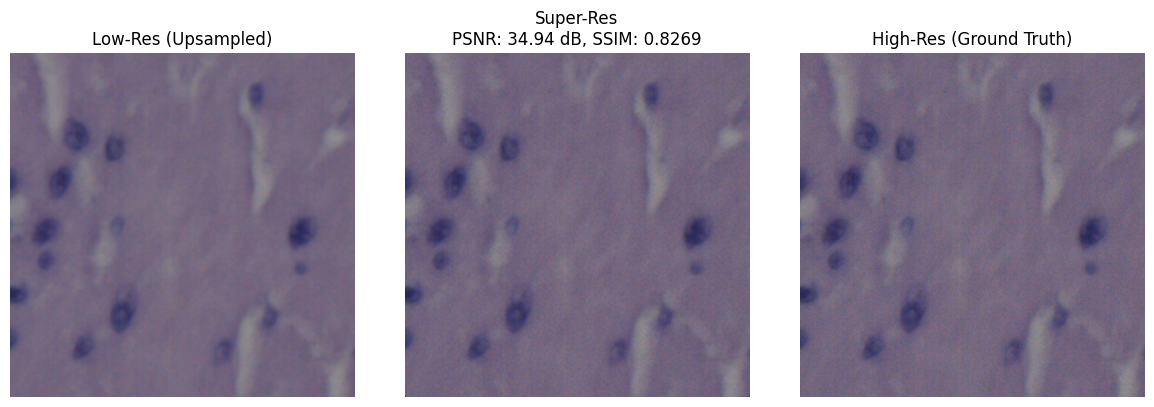

In [14]:
evaluate_sr_quality(model, dataset, device, index=5)
evaluate_sr_quality(model, dataset, device, index=11)


In [15]:
torch.save(model, "srcnn_model.pth")
